In [32]:
!pip install statsmodels

In [35]:
import pandas as pd

# Step 1: Load the Data

In [36]:
df = pd.read_csv('D:/git/sales-forecasting-ml/data/train.csv')



# Step 2: Exploratory Data Analysis (EDA)

In [37]:
df.head()
df.describe()
df.isnull().sum()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [24]:
df['Order Date']

0       08/11/2017
1       08/11/2017
2       12/06/2017
3       11/10/2016
4       11/10/2016
           ...    
9795    21/05/2017
9796    12/01/2016
9797    12/01/2016
9798    12/01/2016
9799    12/01/2016
Name: Order Date, Length: 9800, dtype: object

### Describution of the key Columns

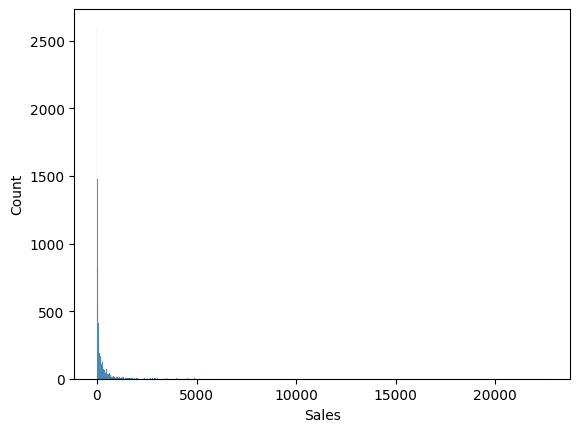

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['Sales'])
plt.show()

# Monthly Sales of all Products over Time

C:\Users\HP\AppData\Local\Temp\ipykernel_22500\4004125652.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M')['Sales'].sum()


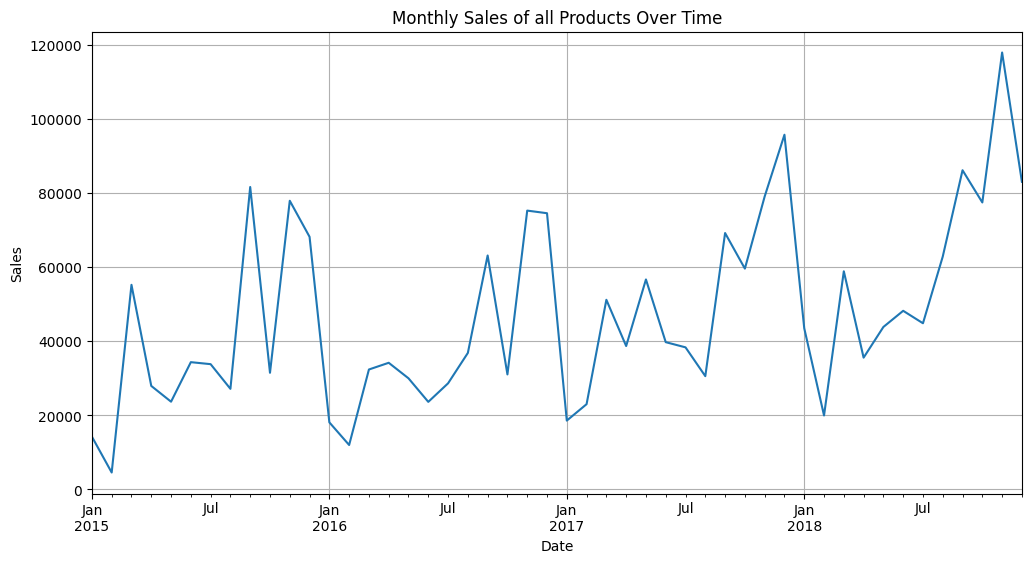

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Order Date' is a column (reset index if needed)
if 'Order Date' not in df.columns:
    df.reset_index(inplace=True)

# Convert 'Order Date' to datetime if not already
if not pd.api.types.is_datetime64_any_dtype(df['Order Date']):
    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')

# Remove rows with invalid dates (NaT)
df.dropna(subset=['Order Date'], inplace=True)

# Set 'Order Date' as index
df.set_index('Order Date', inplace=True)

# Convert 'Sales' to numeric (if it's not already)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

# Drop rows where 'Sales' is NaN
df.dropna(subset=['Sales'], inplace=True)

# Resample by month and calculate total sales
monthly_sales = df.resample('M')['Sales'].sum()

# Plot
plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Monthly Sales of all Products Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [50]:
df['Product ID'].nunique()

Product ID
FUR-BO-10000112     825.174
FUR-BO-10000330    1064.624
FUR-BO-10000362    2154.348
FUR-BO-10000468     723.842
FUR-BO-10000711     851.760
                     ...   
TEC-PH-10004912     351.680
TEC-PH-10004922    1085.238
TEC-PH-10004924      56.164
TEC-PH-10004959     341.666
TEC-PH-10004977    5291.730
Name: Sales, Length: 1861, dtype: float64

In [56]:
df.groupby('Product ID')['Sales'].sum().sort_values(ascending=False).head(5)

Product ID
TEC-CO-10004722    61599.824
OFF-BI-10003527    27453.384
TEC-MA-10002412    22638.480
FUR-CH-10002024    21870.576
OFF-BI-10001359    19823.479
Name: Sales, dtype: float64

## Show the Sale of top 20 product

<Axes: title={'center': 'Top 20 Products by Sales'}, xlabel='Product ID'>

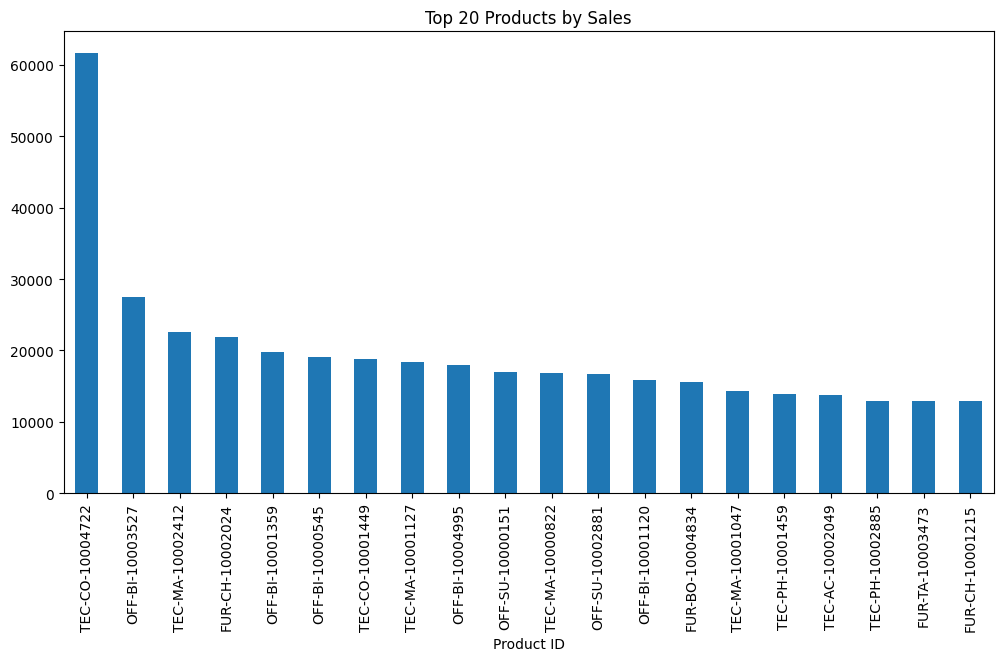

In [44]:
top_products = df.groupby('Product ID')['Sales'].sum().sort_values(ascending=False).head(20)
top_products.plot(kind='bar', figsize=(12,6), title='Top 20 Products by Sales')

# Seasonal Monthly Sales Trends By Year

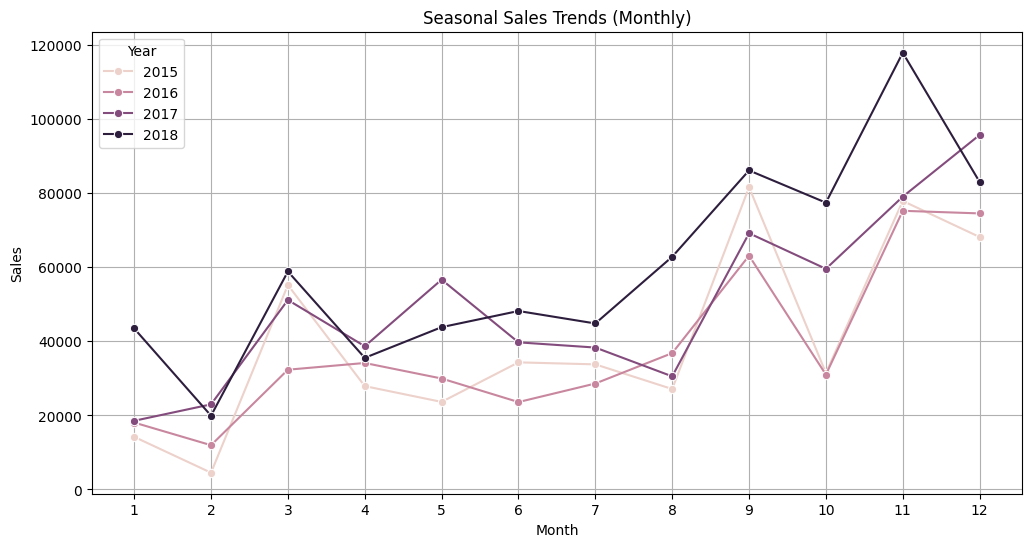

In [46]:
# Ensure 'Order Date' is a column (reset index if necessary)
if df.index.name == 'Order Date':
    df.reset_index(inplace=True)

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

# Extract Year and Month
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Group by Year and Month
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Plot seasonal trends
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', hue='Year', marker='o')
plt.title('Seasonal Sales Trends (Monthly)')
plt.xticks(range(1,13))
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()


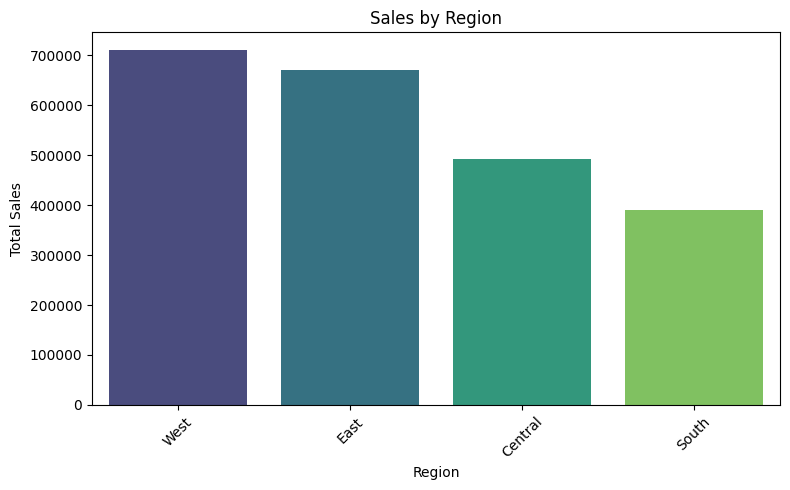

In [47]:
df['Region'].unique()
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=region_sales.index, y=region_sales.values, hue=region_sales.index, palette='viridis', legend=False)
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total Sales for State

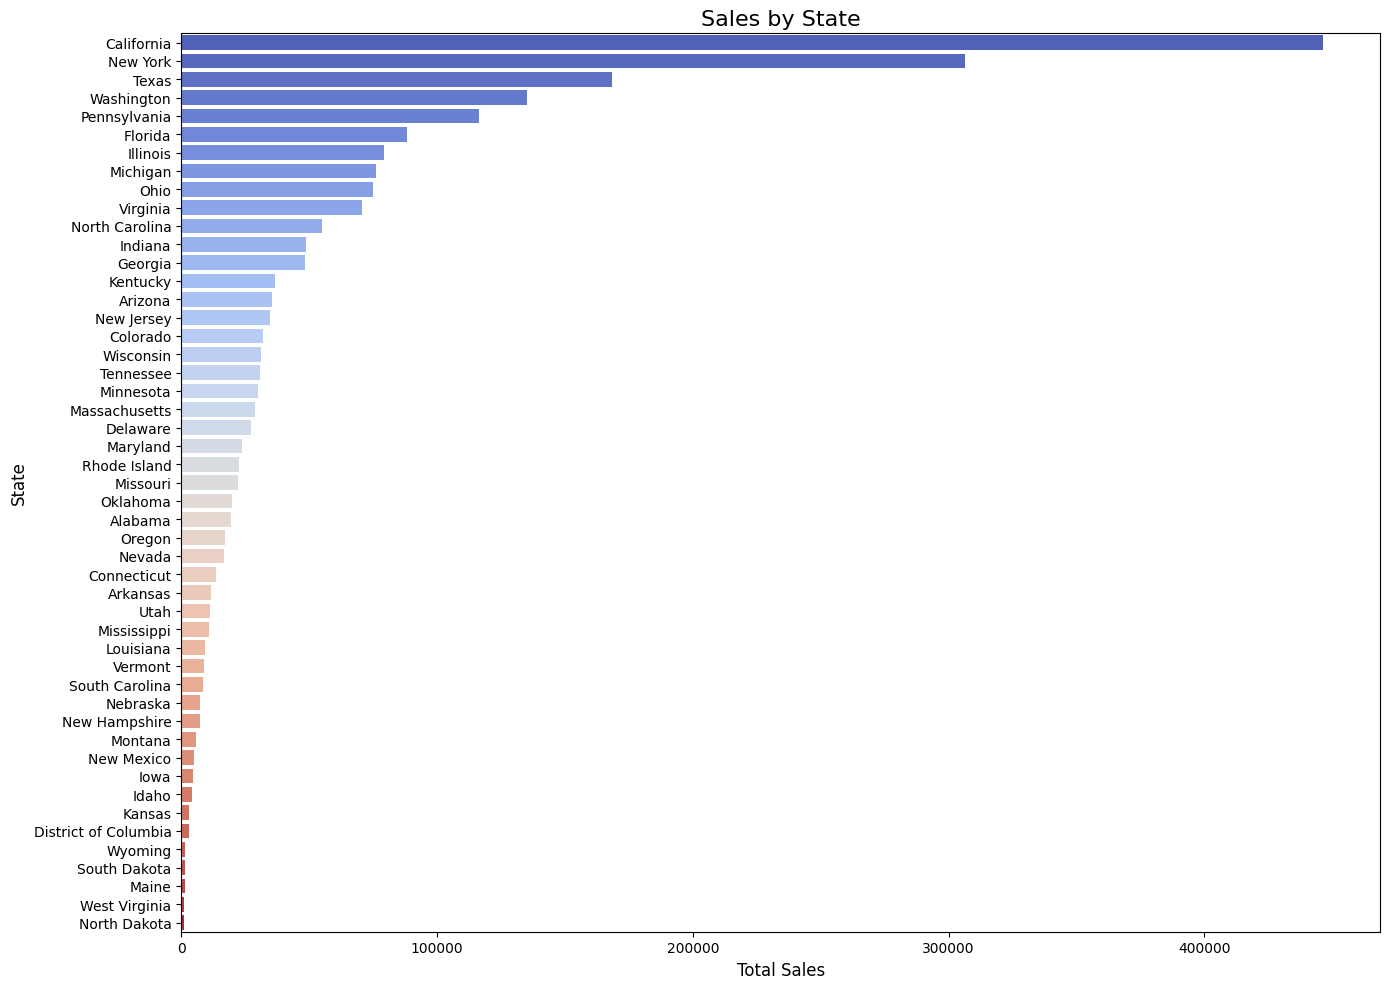

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by State
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(
    x=state_sales.values,
    y=state_sales.index,
    hue=state_sales.index,         # proper hue
    palette='coolwarm',
    dodge=False,                   # make sure bars aren't offset
    legend=False                   # we don't need the legend for states
)

plt.title('Sales by State', fontsize=16)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('State', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


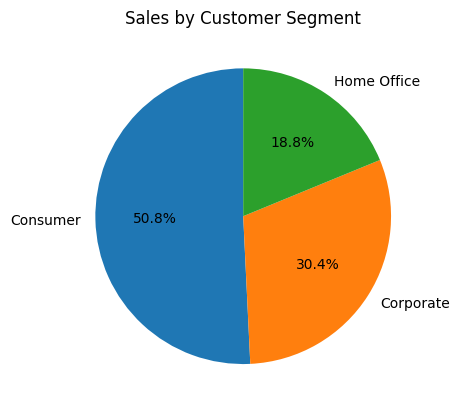

In [46]:
segment_sales = df.groupby('Segment')['Sales'].sum()
segment_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Sales by Customer Segment')
plt.ylabel('')
plt.show()

# Step-by-Step: Sales Forecasting with ARIMA

# That ADF (Augmented Dickey-Fuller) test, if Time Series is Stationary

In [56]:
from statsmodels.tsa.stattools import adfuller

# ADF Test on the 1D Series
result = adfuller(monthly_sales.dropna())

print("===== Augmented Dickey-Fuller Test Results =====")
print(f"ADF Statistic       : {result[0]}")
print(f"p-value             : {result[1]}")
print("Critical Values     :")
for key, value in result[4].items():
    print(f"   {key} level: {value}")
    
# Interpretation
if result[1] <= 0.05:
    print("\n✅ Result: The series is **stationary** (reject H₀)")
else:
    print("\n❌ Result: The series is **non-stationary** (fail to reject H₀)")


===== Augmented Dickey-Fuller Test Results =====
ADF Statistic       : -4.416136761430769
p-value             : 0.00027791039276670623
Critical Values     :
   1% level: -3.5778480370438146
   5% level: -2.925338105429433
   10% level: -2.6007735310095064

✅ Result: The series is **stationary** (reject H₀)


# ARIMA Modeling

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(monthly_sales, order(1,0,